In [3]:
import gzip
from collections import defaultdict
import numpy as np

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before

allRatings = []
userRatings = defaultdict(list)

for user,book,r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  userRatings[user].append(r)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

predictions = open("predictions_Rating.csv", 'w')
for l in open("pairs_Rating.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  if u in userAverage:
    predictions.write(u + ',' + b + ',' + str(userAverage[u]) + '\n')
  else:
    predictions.write(u + ',' + b + ',' + str(globalAverage) + '\n')

predictions.close()

### Would-read baseline: just rank which books are popular and which are not, and return '1' if a book is among the top-ranked

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("train_Interactions.csv.gz"):
  bookCount[book] += 1
  totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalRead/2: break

predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  if b in return1:
    predictions.write(u + ',' + b + ",1\n")
  else:
    predictions.write(u + ',' + b + ",0\n")

predictions.close()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store data
users = []
books = []
ratings = []

# Read data from the CSV file
for user, book, rating in readCSV("train_Interactions.csv.gz"):
    users.append(user)
    books.append(book)
    ratings.append(float(rating))

# Convert lists to NumPy arrays
users_array = np.array(users)
books_array = np.array(books)
ratings_array = np.array(ratings)

# Count frequencies for ratings
unique_ratings, rating_counts = np.unique(ratings_array, return_counts=True)

# Count frequencies for users
unique_users, user_counts = np.unique(users_array, return_counts=True)

# Count frequencies for books
unique_books, book_counts = np.unique(books_array, return_counts=True)

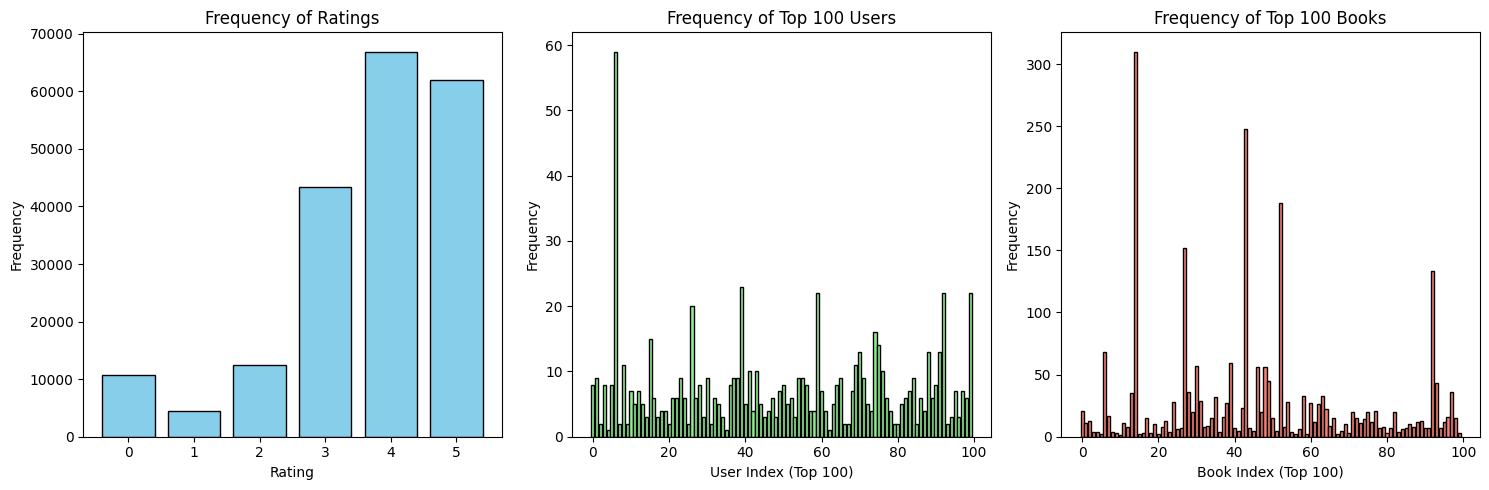

In [10]:
# Plot for ratings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(unique_ratings, rating_counts, color='skyblue', edgecolor='black')
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(unique_ratings)  # Set x-ticks to unique ratings

# Plot for users (show top 10 users for clarity)
top_users = unique_users[:100]
top_user_counts = user_counts[:100]
plt.subplot(1, 3, 2)
plt.bar(range(len(top_users)), top_user_counts, color='lightgreen', edgecolor='black')
plt.title('Frequency of Top 100 Users')
plt.xlabel('User Index (Top 100)')
plt.ylabel('Frequency')

# Plot for books (show top 10 books for clarity)
top_books = unique_books[:100]
top_book_counts = book_counts[:100]
plt.subplot(1, 3, 3)
plt.bar(range(len(top_books)), top_book_counts, color='salmon', edgecolor='black')
plt.title('Frequency of Top 100 Books')
plt.xlabel('Book Index (Top 100)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [11]:
import gzip
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error, accuracy_score # Import sklearn metrics

# Helper function to read the data
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline() # Skip header
    for l in f:
        u,b,r = l.strip().split(',')
        yield u,b,int(r)

# =================================================================
# 1. LOAD AND SPLIT THE DATA
# =================================================================
all_ratings = []
for u, b, r in readCSV("train_Interactions.csv.gz"):
    all_ratings.append((u, b, r))

# Use the same split as the homework
train_set = all_ratings[:190000]
validation_set = all_ratings[190000:]

print(f"Loaded {len(all_ratings)} total interactions.")
print(f"  -> Training set size: {len(train_set)}")
print(f"  -> Validation set size: {len(validation_set)}")

# =================================================================
# 2. "TRAIN" THE PREDICTOR (using ONLY the train_set)
# =================================================================

# Count book frequency *only* in the training set
book_counts_train = defaultdict(int)
for user, book, rating in train_set:
    book_counts_train[book] += 1

# Sort books by popularity
all_books_sorted = sorted(book_counts_train.items(), key=lambda item: item[1], reverse=True)

# Find 50% cutoff
num_unique_books = len(all_books_sorted)
top_50_percent_count = int(num_unique_books * 0.5)

# Create the predictor set
top_50_book_set = set(book_id for book_id, count in all_books_sorted[:top_50_percent_count])

print(f"\nPredictor 'trained' on {len(train_set)} samples.")
print(f"  -> Total unique books in train set: {num_unique_books}")
print(f"  -> Predictor 'top 50%' set contains: {len(top_50_book_set)} books")

# Define the predictor function
def predict_top_50_percent(book_id, top_50_set):
    return 1 if book_id in top_50_set else 0

# =================================================================
# 3. BUILD THE TEST SET (with negative samples)
# =================================================================

# We need all books for negative sampling
all_books_in_data = set(b for u, b, r in all_ratings)
books_per_user = defaultdict(set)
for u, b, r in all_ratings:
    books_per_user[u].add(b)

X_test = [] # The bookID
y_true = [] # The true label (1 for read, 0 for not-read)

# Add positive samples from the validation set
for u, b, r in validation_set:
    X_test.append(b)
    y_true.append(1)

# Add negative samples (this mirrors 'generateValidation')
for u, b, r in validation_set:
    # Find a book this user has *not* read
    unread_books = all_books_in_data - books_per_user[u]
    if unread_books:
        # Sample one random unread book
        negative_book = random.choice(list(unread_books))
        X_test.append(negative_book)
        y_true.append(0)

print(f"\nCreated a test set with {len(y_true)} samples.")
print(f"  -> {y_true.count(1)} positive samples")
print(f"  -> {y_true.count(0)} negative samples")

# =================================================================
# 4. EVALUATE WITH SKLEARN
# =================================================================

# Make predictions on the test set
y_pred = [predict_top_50_percent(book_id, top_50_book_set) for book_id in X_test]

# Calculate and print metrics
mse = mean_squared_error(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print("\n--- Model Evaluation ---")
print(f"  sklearn.metrics.mean_squared_error: {mse:.4f}")
print(f"  sklearn.metrics.accuracy_score:     {accuracy:.4f} (or {accuracy*100:.2f}%)")

print("\nAs you can see, accuracy is more interpretable.")
print(f"This model is correct {accuracy*100:.2f}% of the time on our test set.")

Loaded 200000 total interactions.
  -> Training set size: 190000
  -> Validation set size: 10000

Predictor 'trained' on 190000 samples.
  -> Total unique books in train set: 6684
  -> Predictor 'top 50%' set contains: 3342 books

Created a test set with 20000 samples.
  -> 10000 positive samples
  -> 10000 negative samples

--- Model Evaluation ---
  sklearn.metrics.mean_squared_error: 0.3061
  sklearn.metrics.accuracy_score:     0.6939 (or 69.39%)

As you can see, accuracy is more interpretable.
This model is correct 69.39% of the time on our test set.


In [12]:
import gzip
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import numpy as np

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline() # Skip header
  for l in f:
    yield l.strip().split(',')

# --- 1. Load and Split Data ---
allRatings_data = []
for user,book,r in readCSV("train_Interactions.csv.gz"):
  allRatings_data.append((user, book, int(r)))

# Split into train/validation
train_set = allRatings_data[:190000]
valid_set = allRatings_data[190000:]

# --- 2. Train Model (on train_set ONLY) ---
allRatings_train = []
userRatings_train = defaultdict(list)

for user, book, r in train_set:
  allRatings_train.append(r)
  userRatings_train[user].append(r)

globalAverage = sum(allRatings_train) / len(allRatings_train)
userAverage = {}
for u in userRatings_train:
  userAverage[u] = sum(userRatings_train[u]) / len(userRatings_train[u])

print("--- Rating Model Evaluation (Regression) ---")
print(f"Model trained on {len(train_set)} samples.")

# --- 3. Test Model (on valid_set) ---
y_true = [] # The actual ratings
y_pred = [] # Our model's predictions

for user, book, r_true in valid_set:
    # 'r_true' is the ground truth
    y_true.append(r_true)
    
    # Predict using the model we just trained
    prediction = userAverage.get(user, globalAverage)
    y_pred.append(prediction)

# --- 4. Calculate MSE ---
mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse}")
print("A lower MSE is better.")

--- Rating Model Evaluation (Regression) ---
Model trained on 190000 samples.
Validation MSE: 1.5896213021406507
A lower MSE is better.
